In [1]:
import os.path as osp
import os
import torch
import torch.nn.functional as F
%matplotlib inline
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer
from torch.nn import Sequential, Linear
import tensorflow as tf
import numpy as np
from torch_geometric.data import Data
import random as rn

In [2]:
SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
rn.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

In [3]:
d = np.array([('Sri_Vikrama_Rajasinha_of_Kandy','successor','British_Ceylon'),
('William_IV_of_the_United_Kingdom','predecessor','George_IV_of_the_United_Kingdom'),
('Tvrtko_II_of_Bosnia','successor','Ostoja_of_Bosnia'),
('Alexis_of_Russia','spouse','Maria_Ilyinichna_Miloslavskaya'),
('Haakon_VII_of_Norway','successor','Olav_V_of_Norway')])

In [4]:
entities = list(np.unique(np.concatenate((d[:,0],d[:,2]))))
relations = list(np.unique(d[:,1]))

num_entities = len(entities)
num_relations = len(relations)

ent2idx = dict(zip(entities, range(num_entities)))
rel2idx = dict(zip(relations, range(num_relations)))

In [5]:
X = torch.randn((num_entities, 2))
y = torch.randint(num_relations, (num_entities,))
#edge_index = torch.tensor(([(ent2idx[h],ent2idx[t]) for h,_,t in d]),dtype=torch.long).T
a = np.array([(ent2idx[h],ent2idx[t]) for h,_,t in d]).T
b = np.stack((a[1,:], a[0,:]))
edge_index = torch.tensor(np.concatenate((a,b), axis=1), dtype=torch.long)

data = Data(x=X, y=y, edge_index=edge_index,num_classes=num_relations)

# x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)
# y = torch.tensor([0, 1, 0, 1], dtype=torch.long)
# edge_index = torch.tensor([[0, 1, 2, 0, 3],
#                            [1, 0, 1, 3, 2]], dtype=torch.long)
# data = Data(x=x, y=y, edge_index=edge_index,num_classes=2)

In [6]:
# dataset = 'Cora'
# path = osp.join(osp.dirname(osp.realpath('Untitled.ipynb')), '..', 'data', 'Planetoid')
# dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
# data2 = dataset[0]

# data2.num_classes = 7

# data2

In [7]:
# A = np.zeros(shape=(num_entities,num_entities))

# for h,r,t in d:
    
#     h_idx = entities.index(h)
#     #r_idx = relations.index(r)
#     t_idx = entities.index(t)
    
#     A[h_idx, t_idx] = 1
    
# A = torch.tensor(A, dtype=torch.float)
#A = torch.randn(5,10)
# X = torch.randn(2708,1433)
# y = torch.randint(3, (2708,))

# X = torch.randn(10,1433)
# y = torch.randint(3, (10,))

In [8]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin = Sequential(Linear(10,10))
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits, data.y)
    loss.backward()
    optimizer.step()

explainer = GNNExplainer(model, epochs=200)

Explain node 3: 100%|██████████| 200/200 [00:00<00:00, 577.08it/s]


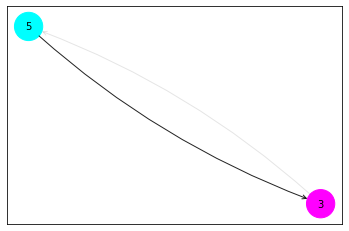

In [9]:
node_idx = 3
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

Explain node 1: 100%|██████████| 200/200 [00:00<00:00, 543.95it/s]


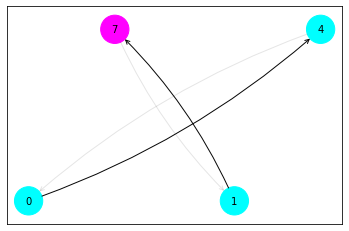

In [11]:
explanations = []

for i in range(2):
    
    node_feat_mask, edge_mask = explainer.explain_node(i, x, edge_index)
    _, G = explainer.visualize_subgraph(i, edge_index, edge_mask, y=data.y)
    
    explanations.append(list(G.edges))

In [54]:
unique_explanations = []
for i in explanations:
    temp = []
    for tup in i:
        sorted_tup = tuple(sorted(tup))
        temp.append(sorted_tup)
    unique_explanations.append(list(set(temp)))

In [55]:
unique_explanations

[[(0, 4)], [(1, 7)]]